In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd
from autograd import grad, elementwise_grad
import autograd.numpy as np
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import erf
from autograd.scipy.special import expit as sigmoid
from autograd.numpy.linalg import solve, cholesky
from autograd.misc.optimizers import adam
from autograd.misc.flatten import flatten_func

## Remedhus

In [3]:
from scipy.io import loadmat
#data = loadmat('../data/gapFilling_DAHRA.mat')
data = loadmat('/media/disk/erc/papers/GapFilling/SMOS/gapFilling_REMEDHUS.mat')

### Selecting a subset of the data and normalizing T so that the model can fit the data. It messes up, at least with the current initialization, if this isnt done. Furthermore, I had to multiply the output by 10 in order to avoid the problem we saw (fits the correct shape but wrong scale).

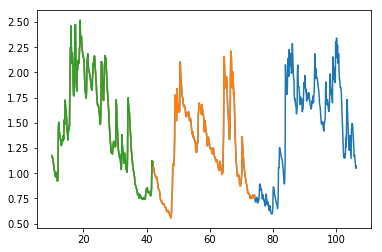

In [4]:
start = 130
stop = int( 3*365 )
T = stop-start
precip = data['insitu_precip'][start:stop]
t=data['utc_ref'][start:stop]
t = (t-np.min(t))/10 + 10
y=data['insitu_sm'][start:stop]*10
ysat=data['SM_both'][start:stop]*10
plt.plot(t,y)
plt.plot(t[0:int(T*2/3)],y[0:int(T*2/3)])
plt.plot(t[0:int(T*1/3)],y[0:int(T*1/3)])
#plt.plot(t,ysat,'.')
#plt.plot(t,precip*0.05)
goods = ~np.isnan(y); t=t[goods].reshape(-1,1); y=y[goods].reshape(-1,1)

#  Three Latent Forces

In [117]:
class LFM:  
    def __init__(self, p, init_logparams = None, nlf = 1, jitter = 1e-10):
        self.p = p
        self.nlf = nlf
        self.jitter = jitter
        self.clamplengthscales = None
        if init_logparams:
            self.logparams = init_logparams
        else:
            self.logparams = {'lengthscales':[np.log(1) for lf in range(nlf)],
                              'decays':[[np.log(1) for i in range(p)] for lf in range(nlf)],
                              'couplings':[[np.log(1) for i in range(p)] for lf in range(nlf)],
                              'sigmas':[np.log(1) for i in range(p)]}

    def hqp(self, T1, T2, Dq, Dp, l):
        """
        TERM1: [ exp(\nu_q^2) / (Dp+Dq) ] * exp(-D_q * T1)
        TERM2: exp(Dq*T2)*[ erf((T1-T2)/l - \nu_q) + erf(T1/l + \nu_q) ]
        TERM3: exp(-Dp*T2)*[ erf(T1/l - \nu_q) + erf(\nu_q) ]
        K = TERM1*(TERM2 - TERM3)
        """
        n1, n2 = len(T1), len(T2)
        T1cols = np.hstack([T1.reshape(n1,1) for i in range(n2)]) 
        T2rows = np.vstack([T2.reshape(1,n2) for i in range(n1)])
    
        nuq = l*Dq*0.5
        TERM1 = np.exp(-Dq * T1cols) * np.exp(nuq**2)/(Dq+Dp)
        TERM2 = np.exp(Dq * T2rows)*( erf((T1cols-T2rows)/l - nuq) + erf(T2rows/l + nuq) )
        TERM3 = np.exp(-Dp * T2rows)*( erf(T1cols/l - nuq) + erf(nuq) )
        return(TERM1*(TERM2-TERM3))

    def simKpq(self, T1, T2, Dp, Dq, l):
        return 0.5*np.sqrt(np.pi)*l*(self.hqp(T1,T2,Dp,Dq,l) + self.hqp(T2,T1,Dq,Dp,l).T )

    def multiK(self, Ttr, decays, lengthscale, couplings):
        ndict= {p:len(Ttr[p]) for p in range(len(Ttr))}
        blockdiag = {i:[] for i in range(self.p)}
        blockoffdiag = {i:[] for i in range(self.p)}
        diagrows, offdiagrows = [], []
        lf = 0
        for i in range(self.p):
            for j in range(self.p):
                blockdiag[i].append(np.zeros([ndict[i],ndict[j]]))
                blockoffdiag[i].append(np.zeros([ndict[i],ndict[j]]))               
                if i == j:
                    blockdiag[i][i] = self.simKpq(Ttr[i], Ttr[i], decays[i], decays[i], lengthscale)*couplings[i]*couplings[j]
                if j > i:
                    blockoffdiag[i][j] = self.simKpq(Ttr[i], Ttr[j], decays[i], decays[j], lengthscale)*couplings[i]*couplings[j]
            diagrows.append( np.hstack( blockdiag[i] ) )
            offdiagrows.append( np.hstack( blockoffdiag[i] ) )
    
        diagK = np.vstack(diagrows)
        offdiagK = np.vstack(offdiagrows)
        return diagK + offdiagK + offdiagK.T
    
    def sigmablocks(self, Ttr, sigmas):
        ndict= {p:len(Ttr[p]) for p in range(len(Ttr))}
        blockdiag = {i:[] for i in range(self.p)}
        blockoffdiag = {i:[] for i in range(self.p)}
        diagrows, offdiagrows = [], []
        lf = 0
        for i in range(self.p):
            for j in range(self.p):
                blockdiag[i].append(np.zeros([ndict[i],ndict[j]]))
                blockoffdiag[i].append(np.zeros([ndict[i],ndict[j]]))               
                if i == j:
                    blockdiag[i][i] = np.eye(ndict[i])*sigmas[i]
            diagrows.append( np.hstack( blockdiag[i] ) )
            offdiagrows.append( np.hstack( blockoffdiag[i] ) )            
    
        diagK = np.vstack(diagrows)
        offdiagK = np.vstack(offdiagrows)
        return diagK + offdiagK + offdiagK.T
    
    def predmultiK(self, Tnew, Ttr, decays, lengthscale, couplings, whichp, latent=False):
        ndict= {p:len(Ttr[p]) for p in range(len(Ttr))}
        blocks = []
        lf = 0
        if latent:
            for i in range(len(Ttr)):
                blocks.append( couplings[i]*self.cross(Ttr[i], Tnew, decays[i], lengthscale).T )
        else:
            for i in range(len(Ttr)):
                blocks.append( couplings[whichp]*couplings[i]*self.simKpq(Tnew, Ttr[i], decays[whichp], decays[i], lengthscale) )
        return np.hstack(blocks)
    
    
    def neg_log_marg_like(self, Ttr, Ytr, logparams):
        """
        Compute negative log marginal likelihood for hyperparameter optimization
        """
        ns = [len(t) for t in Ttr]
        n = sum(ns)
        lengthscales = np.exp(logparams['lengthscales'])
        if self.clamplengthscales:
            lengthscales = np.minimum( np.array([self.clamplengthscales]), lengthscales)
        decays = np.exp(logparams['decays'])
        sigmas = np.exp(logparams['sigmas']) # np.array([0.01,0.2])
        couplings = np.exp(logparams['couplings'])
        #couplings = np.minimum([100*np.var(y) for y in Ytr], couplings) # avoid overfitting
        
        #print(+ np.diag( np.repeat(sigmas,ns) ))
        
        # Lets forget about multiple latent functions for a while 
        K = self.multiK(Ttr, decays, lengthscales[0], couplings[0] ) + self.multiK(Ttr, decays, lengthscales[1], couplings[1] ) + self.multiK(Ttr, decays, lengthscales[2], couplings[2] )
        
        L = cholesky( K + self.jitter*np.eye(n) + self.sigmablocks(Ttr, sigmas) )
        T = np.vstack(Ttr)
        Y = np.vstack(Ytr)
        self.Y = Y
    
        alpha = solve(L.T, solve(L,Y) )
        logmarglike = \
        - 0.5*np.dot(Y.T, alpha)[0,0]     \
        - np.sum( np.log( np.diag( L ) ) )   \
        - 0.5*n*np.log(2*np.pi)
        return -logmarglike
    
    def predict(self, Tnew, Ttr, Ytr, whichp = 0, logparams = None, latent = False): 
        if not logparams:
            logparams = self.logparams
        ns = [len(t) for t in Ttr]
        n = sum(ns)
        lengthscales = np.exp(logparams['lengthscales'])
        if self.clamplengthscales:
            lengthscales = np.minimum( np.array([self.clamplengthscales]), lengthscales)
        decays = np.exp(logparams['decays'])
        sigmas = np.exp(logparams['sigmas']) # np.array([0.01,0.2])
        couplings = np.exp(logparams['couplings'])
        #couplings = np.minimum([100*np.var(y) for y in Ytr], couplings) # avoid overfitting
       
        K = np.sum( [ self.multiK(Ttr, decays, lengthscales[lf], couplings[lf] ) for lf in range(self.nlf) ], 0 )
        L = cholesky( K + self.jitter*np.eye(n) + self.sigmablocks(Ttr, sigmas) )
        T = np.vstack(Ttr)
        Y = np.vstack(Ytr)
        alpha = solve(L.T, solve(L,Y) )
        k = np.sum( [ self.predmultiK(Tnew, Ttr, decays, lengthscales[lf], couplings[lf], whichp=whichp ) for lf in range(self.nlf) ], 0 )
        if latent:
            #k_lf = np.sum( [ self.predmultiK(Tnew, Ttr, decays[lf], lengthscales[lf], couplings[lf], whichp=whichp, latent=True) for lf in range(self.nlf) ], 0 )
            k_lf = np.vstack( [ self.predmultiK(Tnew, Ttr, decays, lengthscales[lf], couplings[lf], whichp=whichp, latent=True) for lf in range(self.nlf) ])
            return np.dot(k, alpha),np.dot(k_lf, alpha), k, k_lf, alpha
        else:
            return np.dot(k, alpha),k
    
    def fit(self, Ttr, Ytr, n_iter=1000, n_update=100, lr = 0.01, jitter = 1e-10):
        print([100*np.var(y) for y in Ytr])
        self.jitter = jitter
        obj = lambda logparams, t: self.neg_log_marg_like(Ttr, Ytr, logparams)
        flat_obj, unflatten, self.flat_logparams = flatten_func(obj, self.logparams)
        for i in range( np.int(n_iter/n_update) ):
        #    print(grad(flat_obj)(self.flat_logparams,0))
            self.flat_logparams = adam(grad(flat_obj), self.flat_logparams, step_size=lr, num_iters=n_update)
            self.logparams = unflatten(self.flat_logparams)
            self.params = unflatten( np.exp(self.flat_logparams) )
            print('Iteration '+str((i+1)*n_update)+'. Current params;')
            for key in self.params.keys():
                if key=='lengthscales' and self.clamplengthscales:
                    print(key,':', np.array([self.clamplengthscales]) )
                    #print(np.array([self.clamplengthscales]), 'vs', self.params[key])                    
                elif key=='couplings':
                    print(key,':', self.params[key])
                    #print(key,':', np.minimum([100*np.var(y) for y in Ytr], self.params[key]))
                    #print([100*np.var(y) for y in Ytr], 'vs', self.params[key])
                else:
                    print(key,':', self.params[key])
            print('nll: ',flat_obj(self.flat_logparams,0),'\n')

    def cross(self, T1, T2, Dq, l):
        """
        (sqrt(pi)*l/2)exp(\nu_q^2)exp(Dq*(T1-T2))*[ erf((T2-T1)/l - \nu_q) + erf(T2/l + \nu_q) ]
        """
        n1, n2 = len(T1), len(T2)
        T1cols = np.hstack([T1.reshape(n1,1) for i in range(n2)]) 
        T2rows = np.vstack([T2.reshape(1,n2) for i in range(n1)])
        nuq = l*Dq*0.5
        print(nuq)
        return (np.sqrt(np.pi)*l/2)*np.exp(nuq*nuq - Dq * (T1cols - T2rows) )*( erf((T1cols-T2rows)/l - nuq) + erf(T2rows/l + nuq) )

## Model insitu+smos, 3lf

In [118]:
nlf = 3; p = 2
initlogparams = {'lengthscales':[np.log(0.1 +np.random.randn()*0.2 + lf**2) for lf in range(nlf)],
                 'decays':[np.log(1)+np.random.randn()*0.1 for p in range(p)],
                 'sigmas':[np.log(0.1) for p in range(p)],
                 'couplings':[[np.log(1) for i in range(p)] for lf in range(nlf)] }

lfm23_both_3lf = LFM(p = p, nlf = nlf, init_logparams=initlogparams)
lfm23_both_3lf.clamplengthscales = None#0.1#0.0005

In [119]:
Ttr = [t23,t23sat]
Ytr = [y23,y23sat]

In [120]:
%%time
lfm23_both_3lf.fit(Ttr, Ytr, n_iter=1000, n_update=50, lr = 0.01)

[21.004495876783103, 56.22584554237402]
Iteration 50. Current params;
lengthscales : [array(0.20387991), array(1.99605001), array(4.59986935)]
decays : [array(0.80577194), array(1.03284069)]
sigmas : [array(0.05981108), array(0.12028725)]
couplings : [[array(0.67017279), array(1.46962575)], [array(0.83027033), array(1.17698902)], [array(1.13765286), array(0.87122107)]]
nll:  [182.56245115] 

Iteration 100. Current params;
lengthscales : [array(0.1788961), array(2.5350235), array(5.48531123)]
decays : [array(0.55134299), array(1.30668181)]
sigmas : [array(0.03652176), array(0.10192823)]
couplings : [[array(0.54447678), array(1.72773117)], [array(0.51294092), array(1.10330658)], [array(0.75216345), array(1.21786795)]]
nll:  [37.56495944] 

Iteration 150. Current params;
lengthscales : [array(0.2124954), array(1.48316363), array(5.78220883)]
decays : [array(0.54836949), array(1.30665104)]
sigmas : [array(0.02228728), array(0.10454662)]
couplings : [[array(0.52867242), array(1.74932657)], 

0.0024420265974312992
0.011879794480510023
0.020143453830819846
0.0979924182191526
0.692991074809822
3.371212891058627


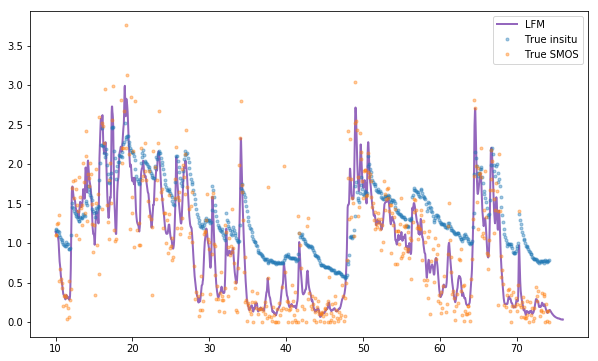

In [123]:
#### Generate test data
%matplotlib inline
plt.figure(figsize=[10,6])
M = 2000
Tnew = t23
Tnew = np.linspace(10,76,M).reshape(M,1)
pred,pred_lf,k,k_lf,alpha = lfm23_both_3lf.predict(Tnew, Ttr, Ytr, whichp=1, latent=True)
plt.plot(Tnew, pred , '-',color='C4',lw=2,label='LFM')
plt.plot(t23,y23,'.',alpha=0.4,color='C0',label='True insitu')
plt.plot(t23sat,y23sat,'.',alpha=0.4,color='C1',label='True SMOS')
plt.legend()

### Latent forces

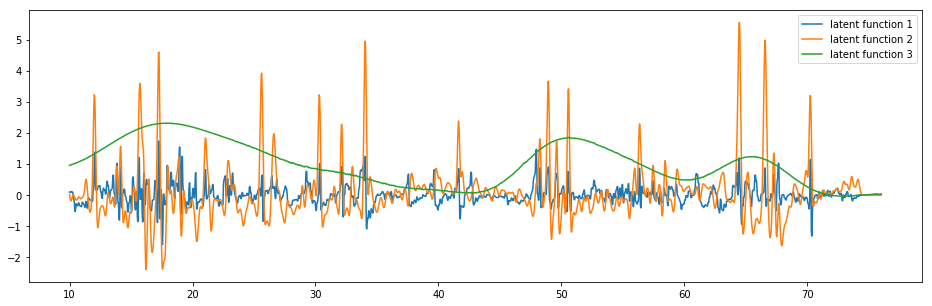

In [124]:
plt.figure(figsize=[16,5])
for lf in range(nlf):
    plt.plot(Tnew,pred_lf[lf*M :(lf+1)*M],label='latent function '+str(lf+1));
plt.legend()

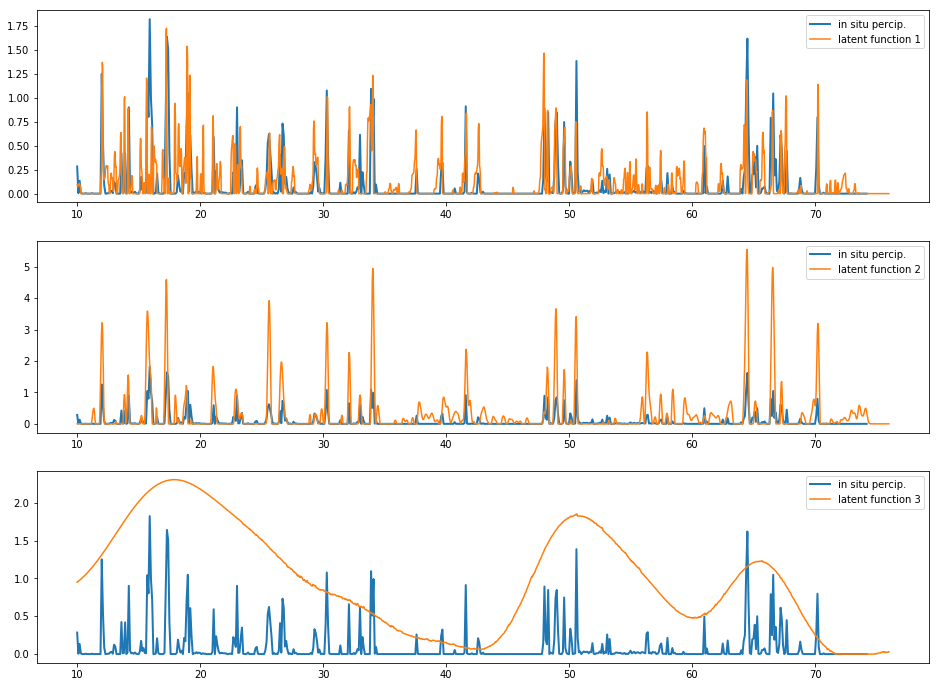

In [126]:
f, ax = plt.subplots(nlf, 1, figsize=[16,12])#, sharey=True)
#plt.plot(t[0:int(T*2/3)],precip[0:int(T*2/3)]*0.1,'-', label='in situ percip.',lw=2)
for lf in range(nlf):
    ax[lf].plot(t[0:int(T*2/3)],precip[0:int(T*2/3)]*0.1,'-', label='in situ percip.',lw=2)
    #ax[lf].plot(Tnew,pred_lf[lf*M :(lf+1)*M],label='latent function '+str(lf+1))
    ax[lf].plot(Tnew,np.maximum(0,pred_lf[lf*M :(lf+1)*M]),label='latent function '+str(lf+1))
    ax[lf].legend()